<a href="https://colab.research.google.com/github/imkaywu/notebooks/blob/main/ocr_tesseract_and_google_vision_api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optical Character Recognition

This notebook explores and compares different methods of optical character recognition Tesseract OCR and Google Vision API. OCR is an important tool, if we want to process large quantities of printed or hand-written textual data. The accompanying blog post can be found [here](https://fuzzylabs.ai/blog/the-battle-of-the-ocr-engines/)

The examples provided:
* Sample prescription (amoxicillin, a type of antibiotic): `gs://fuzzylabs-jupyter-delicacies/amoxicillin_prescription.png`
* Receipt from a hotel (with a hand-written note): `gs://fuzzylabs-jupyter-delicacies/receipt.jpg`
* TT video frame: `data/tt_ocr_test_00.jpeg`

You are encouraged to try it on different images (local files and Google Cloud Storage are supported) to experiment and identify which methods and models best suit your needs.

Run this cell to install the necessary packages, if they are not already installed.

In [29]:
!apt-get install tesseract-ocr libtesseract-dev libleptonica-dev pkg-config

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pkg-config is already the newest version (0.29.2-1ubuntu3).
The following additional packages will be installed:
  libarchive-dev tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  libarchive-dev libleptonica-dev libtesseract-dev tesseract-ocr tesseract-ocr-eng
  tesseract-ocr-osd
0 upgraded, 6 newly installed, 0 to remove and 30 not upgraded.
Need to get 8,560 kB of archives.
After this operation, 31.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libarchive-dev amd64 3.6.0-1ubuntu1 [581 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libleptonica-dev amd64 1.82.0-3build1 [1,562 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libtesseract-dev amd64 4.1.1-2.1build1 [1,600 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cf

In [33]:
!tesseract --version

tesseract 4.1.1
 leptonica-1.82.0
  libgif 5.1.9 : libjpeg 8d (libjpeg-turbo 2.1.1) : libpng 1.6.37 : libtiff 4.3.0 : zlib 1.2.11 : libwebp 1.2.2 : libopenjp2 2.4.0
 Found AVX2
 Found AVX
 Found FMA
 Found SSE
 Found libarchive 3.6.0 zlib/1.2.11 liblzma/5.2.5 bz2lib/1.0.8 liblz4/1.9.3 libzstd/1.4.8


In [1]:
!pip install tesserocr matplotlib opencv-python google-cloud-vision gcsfs

In [34]:
import io
import matplotlib.pyplot as plt
import cv2
import locale
locale.setlocale(locale.LC_ALL, 'C')
from tesserocr import *
from google.cloud import vision
from PIL import Image
import numpy as np
import gcsfs

In [35]:
def show_image(img, title=""):
    plt.figure(figsize=(5,88))
    plt.imshow(img)
    plt.title(title)
    plt.show()

# Accepts either a local file
def imread_wrapper(uri):
    if uri.startswith("gs://"):
        with gcsfs.GCSFileSystem().open(uri, "rb") as f:
            arr = np.asarray(bytearray(f.read()), dtype="uint8")
            img = cv2.imdecode(arr, cv2.IMREAD_COLOR)
            return img
    else: # Assume local file
        return cv2.imread(uri, cv2.IMREAD_COLOR)

Load the image (filename specified in `img`) to run the recognition on.

You can optionally set `PERFORM_THRESHOLDING` to `True`, to perform thresholding. It is advised to preprocess an image if there are unwanted objects in the background (e.g. img/amoxicillin_prescription.png)

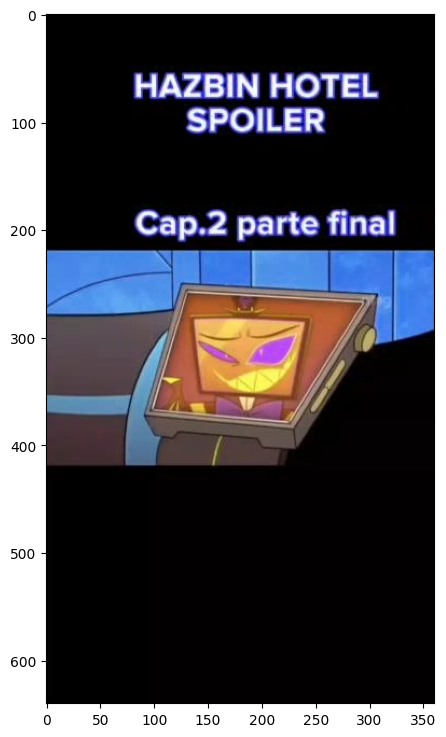

In [93]:
PERFORM_THRESHOLDING = False
img = imread_wrapper("/content/tt_ocr_test_00.jpeg") # see the "data/" directory for test images
if PERFORM_THRESHOLDING:
    _, img = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
show_image(img)

# Tesseract OCR

Tesseract can run in different page segmentation modes. In many cases it is enough to run it on auto (PSM.AUTO), but it is often useful to provide it with some hint on what the layout of the input image is.

We consider three modes here:
* `PSM.SINGLE_BLOCK` -- Assume a single uniform block of text.
* `PSM.SPARSE_TEXT` -- Sparse text. Find as much text as possible in no particular order.
* `PSM.SINGLE_COLUMN` -- Assume a single column of text of variable sizes.

The illustration of how they behave is provided below.

One can read more on different PSMs in Tesseract OCR documentation.

In [80]:
TESSDATA_PREFIX = '/usr/share'

In [88]:
!mkdir -p $TESSDATA_PREFIX
%cd $TESSDATA_PREFIX

/usr/share


In [59]:
!git clone https://github.com/tesseract-ocr/tessdata.git

Cloning into 'tessdata'...
remote: Enumerating objects: 769, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 769 (delta 0), reused 1 (delta 0), pack-reused 768
Receiving objects: 100% (769/769), 3.17 GiB | 23.27 MiB/s, done.
Resolving deltas: 100% (178/178), done.
Updating files: 100% (172/172), done.


In [89]:
%cd /content

/content


In [81]:
import tesserocr
from tesserocr import get_languages

print(tesserocr.tesseract_version())
print(get_languages(TESSDATA_PREFIX))

tesseract 5.3.3
 leptonica-1.83.1
  libpng 1.6.34 : zlib 1.2.11
('/usr/share/', ['tessdata/afr', 'tessdata/amh', 'tessdata/ara', 'tessdata/asm', 'tessdata/aze', 'tessdata/aze_cyrl', 'tessdata/bel', 'tessdata/ben', 'tessdata/bod', 'tessdata/bos', 'tessdata/bre', 'tessdata/bul', 'tessdata/cat', 'tessdata/ceb', 'tessdata/ces', 'tessdata/chi_sim', 'tessdata/chi_sim_vert', 'tessdata/chi_tra', 'tessdata/chi_tra_vert', 'tessdata/chr', 'tessdata/cos', 'tessdata/cym', 'tessdata/dan', 'tessdata/dan_frak', 'tessdata/deu', 'tessdata/deu_frak', 'tessdata/div', 'tessdata/dzo', 'tessdata/ell', 'tessdata/eng', 'tessdata/enm', 'tessdata/epo', 'tessdata/equ', 'tessdata/est', 'tessdata/eus', 'tessdata/fao', 'tessdata/fas', 'tessdata/fil', 'tessdata/fin', 'tessdata/fra', 'tessdata/frk', 'tessdata/frm', 'tessdata/fry', 'tessdata/gla', 'tessdata/gle', 'tessdata/glg', 'tessdata/grc', 'tessdata/guj', 'tessdata/hat', 'tessdata/heb', 'tessdata/hin', 'tessdata/hrv', 'tessdata/hun', 'tessdata/hye', 'tessdata/iku'

In [83]:
from tesserocr import PyTessBaseAPI, PSM

tesseract_modes = [
    ("Tesseract SINGLE BLOCK", PyTessBaseAPI(path=f'{TESSDATA_PREFIX}/tessdata', psm=PSM.SINGLE_BLOCK)),
    ("Tesseract SPARSE TEXT", PyTessBaseAPI(path=f'{TESSDATA_PREFIX}/tessdata', psm=PSM.SPARSE_TEXT)),
    ("Tesseract SINGLE COLUMN", PyTessBaseAPI(path=f'{TESSDATA_PREFIX}/tessdata', psm=PSM.SINGLE_COLUMN))
]

In [84]:
def tesseract_ocr(tesseract, img):
    pil_image = Image.fromarray(img)
    tesseract.SetImage(pil_image)
    tesseract.Recognize()
    return tesseract.GetIterator()

def display_tesseract_results(img, level):
    n = len(tesseract_modes)
    fig, axs = plt.subplots(1,n, figsize=(5*n, 88))
    for (name, tesseract), ax in zip(tesseract_modes, axs):
        results = tesseract_ocr(tesseract, img)
        _img = img.copy()
        tokens = []
        for r in iterate_level(results, level):
            text = r.GetUTF8Text(level)
            tokens += [text]
            bb = r.BoundingBox(level)
            cv2.rectangle(_img, (bb[0], bb[1]), (bb[2], bb[3]), (255, 0, 0), 2)
        print(name)
        print(tokens)
        print()
        ax.set_title(name)
        ax.imshow(_img)

The results (i.e. recognised texts and their locations) that are returned by Tesseract are arranged in a hierarchy, and therefore can be accessed at different levels. In this notebook, we show the results by paragraph, text line and word. One may find other levels (namely blocks of text and characters) useful for their application.

## By paragraph

Tesseract SINGLE BLOCK
["HAZBIN HOTEL\nSPOILER\nCap.2 parte final\n1, —~wor 777'7}\ni (,\nS—\n\n"]

Tesseract SPARSE TEXT
['HAZBIN HOTEL\n\n', 'Cap.2 parte final\n\n', '——fl/\n\n']

Tesseract SINGLE COLUMN
[' \n\n']



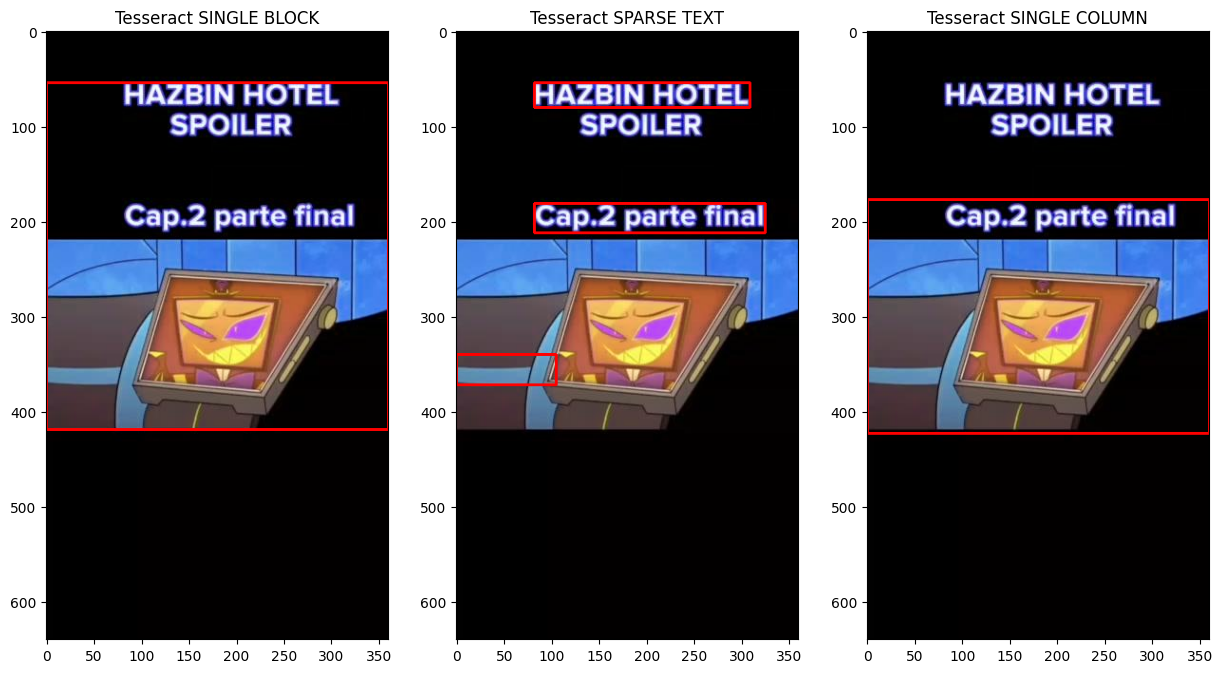

In [85]:
display_tesseract_results(img, RIL.PARA)

## By text line

Tesseract SINGLE BLOCK
['HAZBIN HOTEL\n', 'SPOILER\n', 'Cap.2 parte final\n', "1, —~wor 777'7}\n", 'i (,\n', 'S—\n\n']

Tesseract SPARSE TEXT
['HAZBIN HOTEL\n\n', 'Cap.2 parte final\n\n', '——fl/\n\n']

Tesseract SINGLE COLUMN
[' \n\n']



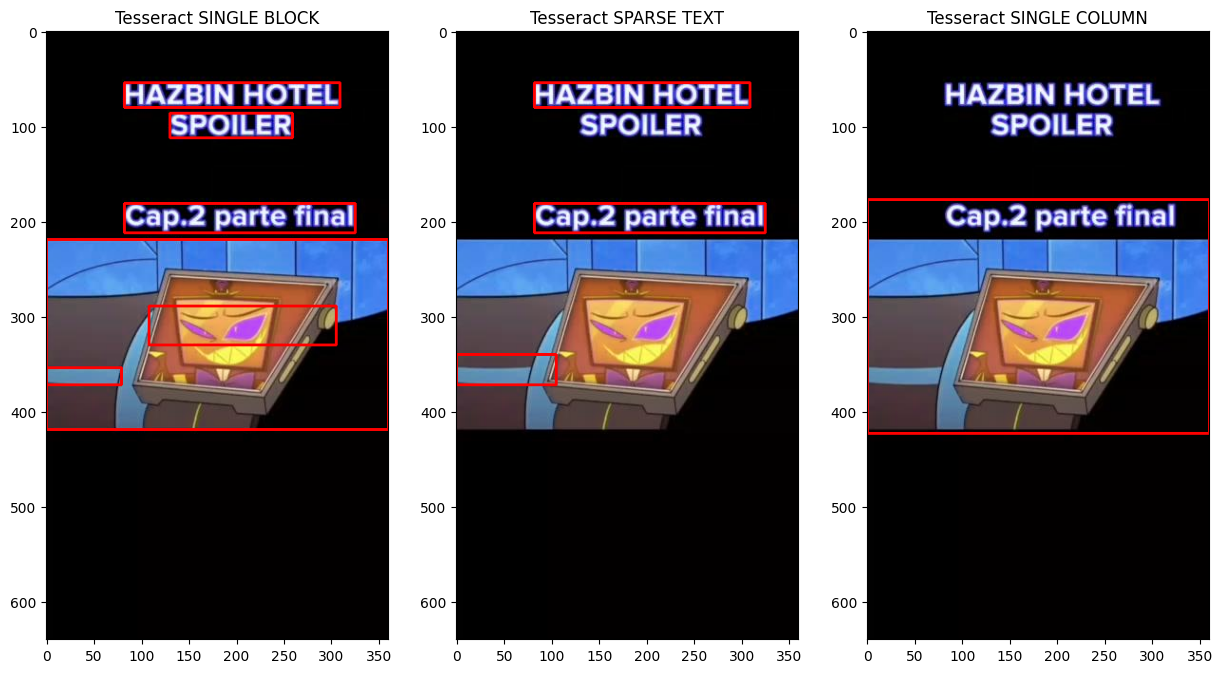

In [86]:
display_tesseract_results(img, RIL.TEXTLINE)

## By word

Tesseract SINGLE BLOCK
['HAZBIN', 'HOTEL', 'SPOILER', 'Cap.2', 'parte', 'final', '1,', '—~wor', "777'7}", 'i', '(,', 'S—']

Tesseract SPARSE TEXT
['HAZBIN', 'HOTEL', 'Cap.2', 'parte', 'final', '——fl/']

Tesseract SINGLE COLUMN
[' ']



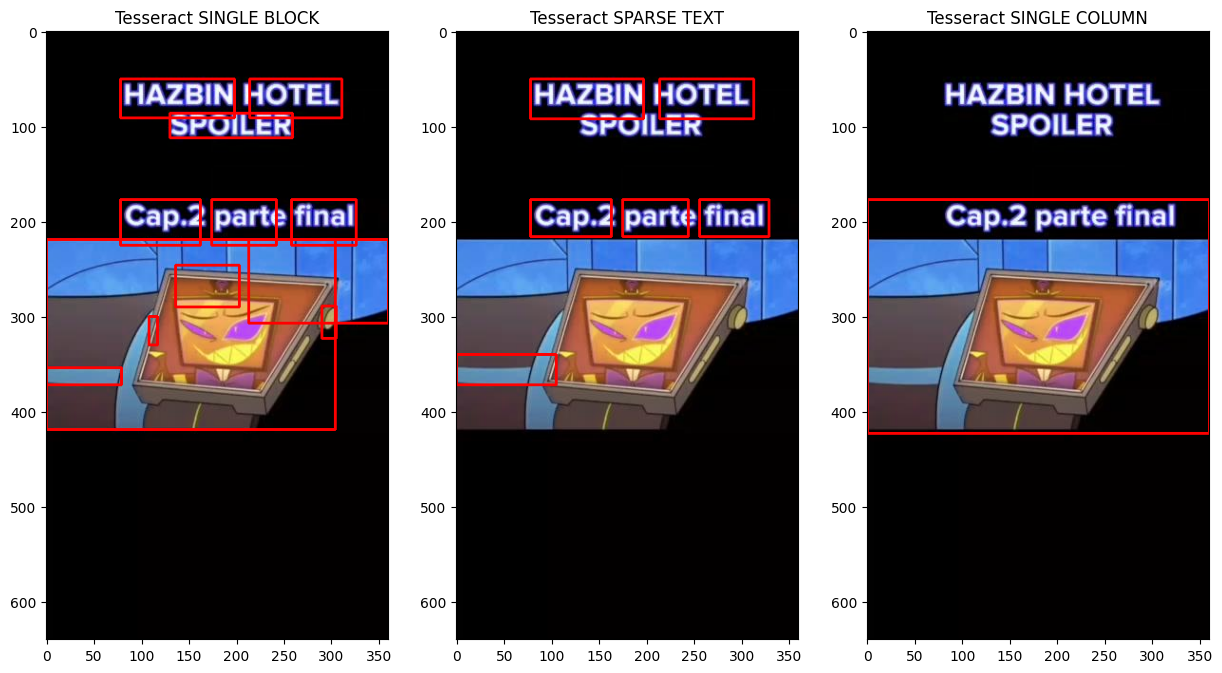

In [87]:
display_tesseract_results(img, RIL.WORD)

# Google Vision API

**NOTE: this section has NOT been tested yet**

As an alternative to Tesseract OCR, we also explore Google Vision. As opposed to Tesseract, it does not run locally, but on the Google's servers. In order to use it, valid credentials need to be provided in `GOOGLE_APPLICATION_CREDENTIALS` environment variable (more details in the Google's documentation)



In [15]:
google_image_annotator = vision.ImageAnnotatorClient()

In [16]:
def google_document_text_detection(img):
    buf = io.BytesIO()
    img_pil = Image.fromarray(img)
    img_pil.save(buf, 'PNG')
    byte_image = buf.getvalue()

    document_image = vision.types.Image(content=byte_image)
    image_response = google_image_annotator.document_text_detection(image=document_image, image_context={"language_hints": ["en"]})
    page = image_response.full_text_annotation.pages[0]
    return page

def google_text_detection(img):
    buf = io.BytesIO()
    img_pil = Image.fromarray(img)
    img_pil.save(buf, 'PNG')
    byte_image = buf.getvalue()

    document_image = vision.types.Image(content=byte_image)
    image_response = google_image_annotator.text_detection(image=document_image, image_context={"language_hints": ["en"]})
    page = image_response.full_text_annotation.pages[0]
    return page

Google Vision API does not have options for differents modes of page segmentation, however there's still some degree of flexibility provided. There are two models that are tuned on two different tasks:

* Text Detection model -- detects and extracts text from any image
* Document Text Detection model -- performs the same operation, but is tuned for dense texts and documents

The choice of the model depends on the nature and structure of the images to be recognised (same as with PSM of Tesseract OCR). We show the results produced by both models in this notebook.

In [ ]:
pages = [
    ("Google Text Detection", google_text_detection(img)),
    ("Google Document Text Detection", google_document_text_detection(img)),
]

In [ ]:
def get_symbol_text(symbol):
    text = symbol.text
    if symbol.property.HasField('detected_break'):
        if symbol.property.detected_break == vision.enums.TextAnnotation.DetectedBreak.BreakType.LINE_BREAK:
            text += "\n"
        else:
            text += " "
    return text

def get_word_text(word):
    return "".join([get_symbol_text(x) for x in word.symbols])

def get_paragraph_text(para):
    return "".join([get_word_text(x) for x in para.words])

def get_block_text(block):
    return "".join([get_paragraph_text(x) for x in block.paragraphs])

In [ ]:
def add_bounding_box(img, bb):
    cv2.polylines(img, [np.array([[point.x, point.y] for point in bb])], True, (255, 0, 0), 2)


def get_google_words(page, img):
    _img = img.copy()
    texts = []
    for block in page.blocks:
        for para in block.paragraphs:
            for word in para.words:
                texts += [get_word_text(word)]
                add_bounding_box(_img, word.bounding_box.vertices)
    return texts, _img

def get_google_paragraphs(page, img):
    _img = img.copy()
    texts = []
    for block in page.blocks:
        for para in block.paragraphs:
            texts += [get_paragraph_text(para)]
            add_bounding_box(_img, para.bounding_box.vertices)
    return texts, _img

def get_google_blocks(page, img):
    _img = img.copy()
    texts = []
    for block in page.blocks:
        texts += [get_block_text(block)]
        add_bounding_box(_img, block.bounding_box.vertices)
    return texts, _img

def display_google_results(pages, img, func):
    n = len(pages)
    fig, axs = plt.subplots(1,n, figsize=(5*n, 88))
    for (name, page), ax in zip(pages, axs):
        texts, _img = func(page, img)
        print(name)
        print(texts)
        print()
        ax.imshow(_img)
        ax.set_title(name)
    plt.show()

Similar to Tesseract OCR, Google Vision also provides results in a hierarchical manner. Hence, they can be browsed at different levels. As an example, iteration over text blocks, paragraphs and individual words are shown below.

## By text block

In [ ]:
display_google_results(pages, img, get_google_blocks)

## By paragraph

In [ ]:
display_google_results(pages, img, get_google_paragraphs)

## By word

In [ ]:
display_google_results(pages, img, get_google_words)